In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support

import seaborn as sn
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

In [17]:
__file__ = 'Routine Healthcare Screening - Covid Modelling.ipynb'
root_dir = os.path.abspath(os.path.join(__file__, "../../"))
input_data_path = os.path.join(root_dir, 'data/AEH_Br_dataset_for_modelling_2.csv')

test_output_path = os.path.join(root_dir, 'output/test_predictions_2.csv')
train_output_path = os.path.join(root_dir, 'output/train_predictions_2.csv')

In [18]:
df = pd.read_csv(input_data_path)

In [19]:
df.isnull().sum()

% Fields available                                         0
Patient ID                                                 0
Patient age quantile                                       0
SARS-Cov-2 exam result                                     0
Patient addmited to regular ward (1=yes, 0=no)             0
Patient addmited to semi-intensive unit (1=yes, 0=no)      0
Patient addmited to intensive care unit (1=yes, 0=no)      0
Hematocrit                                                 0
Hemoglobin                                                 0
Platelets                                                  0
Lymphocytes                                                0
Basophils                                                  0
Eosinophils                                                0
Mean corpuscular volume (MCV)                              0
Monocytes                                                  0
Neutrophils                                               57
Urea                    

In [20]:
df.describe()

,% Fields available,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Lymphocytes,Basophils,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Neutrophils,Urea,Creatinine,Potassium,Sodium
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,471.000000,355.000000,381.000000,334.000000,331.000000
mean,88.811189,12.530303,0.153409,0.102273,0.060606,0.030303,0.107940,0.094665,-0.064427,-0.023248,0.072436,0.029148,0.125754,0.042289,-0.002246,0.061010,0.152697,-0.011266,0.013463
std,13.540426,4.647644,0.360723,0.303294,0.238833,0.171582,0.957498,0.969029,0.956527,0.931789,1.009286,1.004837,0.908551,0.989467,0.991734,1.026779,0.911989,0.978925,1.007293
min,61.538462,4.000000,0.000000,0.000000,0.000000,0.000000,-4.501420,-4.345603,-2.552426,-1.865070,-1.140144,-0.835508,-5.101581,-2.163721,-2.872669,-1.630410,-1.666318,-2.035918,-5.246946
25%,69.230769,9.000000,0.000000,0.000000,0.000000,0.000000,-0.450142,-0.460932,-0.617907,-0.722178,-0.529226,-0.624811,-0.394636,-0.535402,-0.651866,-0.551126,-0.529106,-0.800110,-0.575008
50%,100.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.167850,0.165628,-0.159401,-0.031325,-0.223767,-0.245556,0.146163,-0.088928,-0.061837,-0.067309,0.056730,-0.058626,0.143752
75%,100.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.768674,0.792188,0.437284,0.574237,0.692611,0.344395,0.666931,0.515126,0.675699,0.453725,0.573645,0.682859,0.503132
max,100.000000,19.000000,1.000000,1.000000,1.000000,1.000000,2.662704,2.671868,9.532034,3.218241,11.078219,8.350876,3.410980,4.533397,2.535929,11.246569,5.053572,3.401635,4.096930


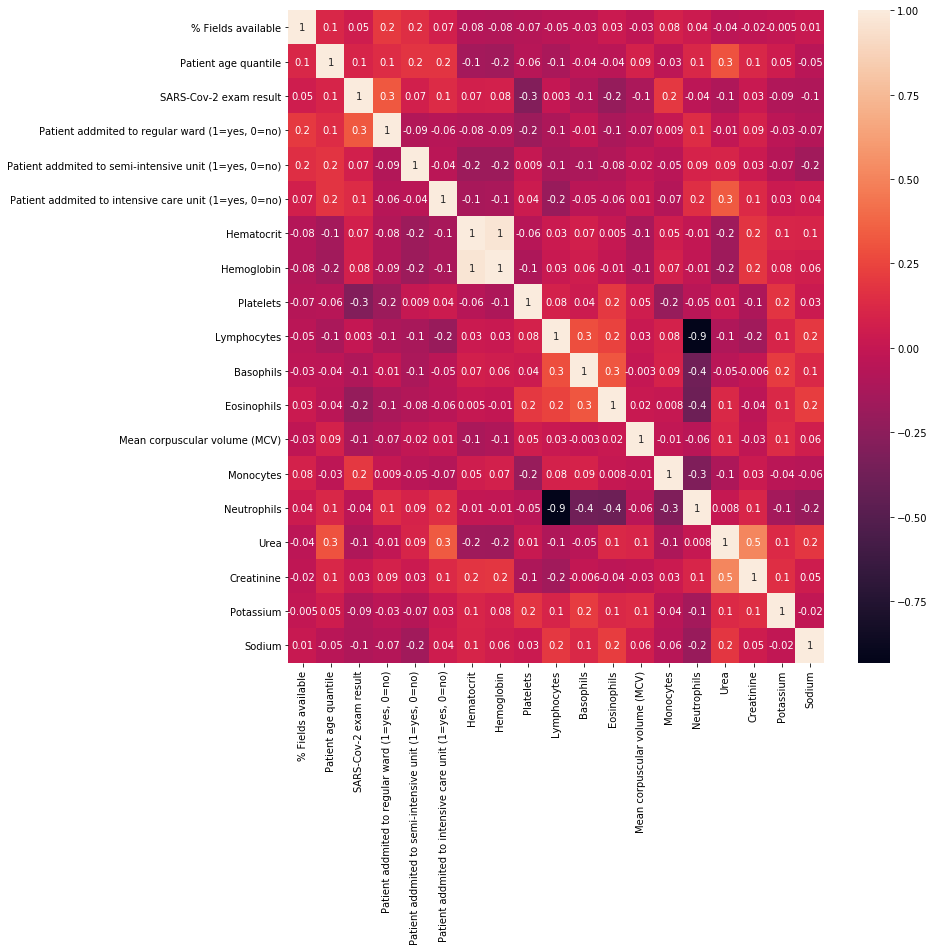

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
sn.heatmap(ax=ax, data=df.corr(), annot=True, fmt='.1g')

## Impute Missing Values and Normalize

In [22]:
drop_columns = ['% Fields available','Patient ID','SARS-Cov-2 exam result',
             'Patient addmited to regular ward (1=yes, 0=no)',
             'Patient addmited to semi-intensive unit (1=yes, 0=no)',
             'Patient addmited to intensive care unit (1=yes, 0=no)']
df_temp = df.drop(columns=drop_columns)

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(df_temp)
df_imputed = imputer.transform(df_temp)

df_imputed = pd.DataFrame(df_imputed)
df_imputed = pd.concat([df[drop_columns]
                        , df_imputed]
                       , axis=1)
df_imputed.columns=drop_columns+list(df_temp.columns)

In [23]:
df_imputed.isnull().sum()

% Fields available                                       0
Patient ID                                               0
SARS-Cov-2 exam result                                   0
Patient addmited to regular ward (1=yes, 0=no)           0
Patient addmited to semi-intensive unit (1=yes, 0=no)    0
Patient addmited to intensive care unit (1=yes, 0=no)    0
Patient age quantile                                     0
Hematocrit                                               0
Hemoglobin                                               0
Platelets                                                0
Lymphocytes                                              0
Basophils                                                0
Eosinophils                                              0
Mean corpuscular volume (MCV)                            0
Monocytes                                                0
Neutrophils                                              0
Urea                                                    

In [24]:
df_imputed.describe()

,% Fields available,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Patient age quantile,Hematocrit,Hemoglobin,Platelets,Lymphocytes,Basophils,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Neutrophils,Urea,Creatinine,Potassium,Sodium
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,88.811189,0.153409,0.102273,0.060606,0.030303,12.530303,0.107940,0.094665,-0.064427,-0.023248,0.072436,0.029148,0.125754,0.042289,0.056545,0.027058,0.136395,0.000824,0.044786
std,13.540426,0.360723,0.303294,0.238833,0.171582,4.647644,0.957498,0.969029,0.956527,0.931789,1.009286,1.004837,0.908551,0.989467,0.981288,0.863695,0.814678,0.819273,0.829570
min,61.538462,0.000000,0.000000,0.000000,0.000000,4.000000,-4.501420,-4.345603,-2.552426,-1.865070,-1.140144,-0.835508,-5.101581,-2.163721,-2.872669,-1.630410,-1.666318,-2.035918,-5.246946
25%,69.230769,0.000000,0.000000,0.000000,0.000000,9.000000,-0.450142,-0.460932,-0.617907,-0.722178,-0.529226,-0.624811,-0.394636,-0.535402,-0.621135,-0.439476,-0.413662,-0.552949,-0.287504
50%,100.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.167850,0.165628,-0.159401,-0.031325,-0.223767,-0.245556,0.146163,-0.088928,0.020112,-0.067309,0.056730,-0.058626,0.143752
75%,100.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.768674,0.792188,0.437284,0.574237,0.692611,0.344395,0.666931,0.515126,0.745356,0.304858,0.525400,0.435697,0.503132
max,100.000000,1.000000,1.000000,1.000000,1.000000,19.000000,2.662704,2.671868,9.532034,3.218241,11.078219,8.350876,3.410980,4.533397,2.535929,11.246569,5.053572,3.401635,4.096930


## Normalize data

In [25]:
df_temp = df_imputed.drop(columns=drop_columns)

df_imputed_norm = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

df_imputed_norm = pd.concat([df_imputed[drop_columns]
                        , df_imputed_norm]
                       , axis=1)

In [26]:
df_imputed_norm.describe()

,% Fields available,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Patient age quantile,Hematocrit,Hemoglobin,Platelets,Lymphocytes,Basophils,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Neutrophils,Urea,Creatinine,Potassium,Sodium
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,88.811189,0.153409,0.102273,0.060606,0.030303,0.568687,0.643395,0.632745,0.205884,0.362327,0.099242,0.094124,0.614073,0.329397,0.541585,0.128716,0.268265,0.374570,0.566332
std,13.540426,0.360723,0.303294,0.238833,0.171582,0.309843,0.133652,0.138088,0.079154,0.183304,0.082604,0.109383,0.106731,0.147745,0.181431,0.067073,0.121234,0.150669,0.088782
min,61.538462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.230769,0.000000,0.000000,0.000000,0.000000,0.333333,0.565495,0.553571,0.160083,0.224832,0.050000,0.022936,0.552941,0.243137,0.416288,0.092486,0.186410,0.272727,0.530769
50%,100.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.651757,0.642857,0.198025,0.360738,0.075000,0.064220,0.616471,0.309804,0.534848,0.121387,0.256410,0.363636,0.576923
75%,100.000000,0.000000,0.000000,0.000000,0.000000,0.866667,0.735623,0.732143,0.247401,0.479866,0.150000,0.128440,0.677647,0.400000,0.668939,0.150289,0.326154,0.454545,0.615385
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Random Forest Classifier

In [56]:
labels = np.array(df_imputed_norm['SARS-Cov-2 exam result'])
features = df_imputed_norm.drop(drop_columns+['Urea','Creatinine','Potassium','Sodium'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

In [57]:
train_indices = []
test_indices = []

split_res = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=8)
for train_index, test_index in split_res.split(features, labels):
    train_indices.append(train_index)
    test_indices.append(test_index)
train_indices = train_indices[0]
test_indices = test_indices[0]

print('Training samples:',len(train_indices))
print('Positives in training sample:',labels[train_indices].sum())
print('Testing samples:',len(test_indices))
print('Positives in testing sample:',labels[test_indices].sum())

Training samples: 369
Positives in training sample: 57
Testing samples: 159
Positives in testing sample: 24


In [77]:
model = RandomForestClassifier(n_estimators=5, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(features[train_indices], labels[train_indices])
rf_predictions = model.predict(features[test_indices])

In [78]:
print('Accuracy:',accuracy_score(labels[test_indices],rf_predictions))
print('Precision and Recall:',precision_recall_fscore_support(np.array(labels[test_indices]),np.array(rf_predictions)))
print('ROC:',roc_auc_score(labels[test_indices],rf_predictions))

Accuracy: 0.8805031446540881
Precision and Recall: (array([0.9 , 0.67]), array([0.96, 0.42]), array([0.93, 0.51]), array([135,  24], dtype=int64))
ROC: 0.6898148148148149


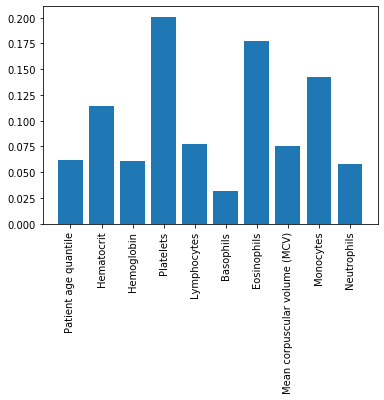

In [79]:
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=range(len(feature_list)),labels=feature_list,rotation=90)
plt.show()

In [83]:
df_output = pd.concat([pd.DataFrame(df.loc[test_indices,feature_list].reset_index(drop=True))
                       ,pd.DataFrame(labels[test_indices])
                       ,pd.DataFrame(rf_predictions)], axis=1, ignore_index=True)
df_output.columns=feature_list+['SARS-Cov-2 exam result','Prediction']
df_output.to_csv(test_output_path)

rf_train_predictions = model.predict(features[train_indices])
df_train_output = pd.concat([pd.DataFrame(df.loc[train_indices,feature_list].reset_index(drop=True))
                       ,pd.DataFrame(labels[train_indices])
                       ,pd.DataFrame(rf_train_predictions)], axis=1, ignore_index=True)
df_train_output.columns=feature_list+['SARS-Cov-2 exam result','Prediction']
df_train_output.to_csv(train_output_path)

In [84]:
print('Accuracy:',accuracy_score(labels[train_indices],rf_train_predictions))
print('Precision and Recall:',precision_recall_fscore_support(np.array(labels[train_indices]),np.array(rf_train_predictions)))
print('ROC:',roc_auc_score(labels[train_indices],rf_train_predictions))

Accuracy: 0.989159891598916
Precision and Recall: (array([0.99, 1.  ]), array([1.  , 0.93]), array([0.99, 0.96]), array([312,  57], dtype=int64))
ROC: 0.9649122807017544
